# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import pandas as pd

os.chdir(r"/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/Гринатом")
print(os.getcwd())

url = os.getcwd()
files = os.listdir(url)
files

/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/Гринатом


['imdb.vocab',
 'IMBD_Train.csv',
 'IMBD_Test.csv',
 'special_tokens_map.json',
 'tokenizer_config.json',
 'vocab.txt',
 'bert_classifier_imdb.pth',
 'wandb',
 'model_bert-base-uncased.pt',
 'model_review_bert-base-uncased.pt',
 'bert_regressor_imdb.pth',
 'bert_regressor_imdb_v2.pth']

In [ ]:
test = pd.read_csv('IMBD_Test.csv')
df = pd.read_csv('IMBD_Train.csv')

In [ ]:
test.loc[156,:]

Unnamed: 0                                                  156
Text          Martino, a young teacher in the island of Elba...
Sentiment                                                     1
rate                                                          7
Name: 156, dtype: object

In [ ]:
test.loc[156,"Text"]

'Martino, a young teacher in the island of Elba, has been formed by Maestro Fontanelli, an excellent educator, to be his own man and to say whatever he thinks, something that gets him in trouble at the school where we first meet him because he is teaching revolutionary ideals. The island is in a frenzy because of the arrival of one of the most influential men in European history of the 19th century. Napoleon is coming to his exile, not exactly a high point in his life.<br /><br />With surprise, Martino is chosen to accompany Napoleon who is writing his memoirs and is in need of help for his own project. The young man comes from a sea merchant family. His brother and sister want him to go on an commercial expedition, but Martino has decided his place belongs in Elba because he will try to assassinate Napoleon. Little deters him after his mentor Fontanelli is tried for treason and condemned to be shot by a firing squad.<br /><br />Martino finds his consolation with the much older Barones

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Предобработка данных и создание DataLoader
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, ratings, tokenizer, max_length):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = str(self.reviews[index])
        rating = float(self.ratings[index])

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt',
            return_attention_mask=True,
            return_token_type_ids=False
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'rating': torch.tensor(rating)
        }

In [ ]:
# Создание модели

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to(device)
model = model.float()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Задаем параметры обучения
batch_size = 16
max_length = 128
epochs = 5
learning_rate = 2e-5

# Подготовка данных и Создание DataLoader
texts = df['Text'].values
labels = df['rate'].values
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = ReviewDataset(train_texts, train_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ReviewDataset(val_texts, val_labels, tokenizer, max_length)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Validation: 100%|██████████| 313/313 [01:02<00:00,  5.01it/s]


Epoch 1/5 - Train Loss: 6.4723 - Valid Loss: 3.9624


Validation: 100%|██████████| 313/313 [01:02<00:00,  5.00it/s]


Epoch 2/5 - Train Loss: 2.8521 - Valid Loss: 3.9114


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


Epoch 3/5 - Train Loss: 1.7697 - Valid Loss: 4.3668


Validation: 100%|██████████| 313/313 [01:02<00:00,  5.02it/s]


Epoch 4/5 - Train Loss: 1.2564 - Valid Loss: 4.2069


Validation: 100%|██████████| 313/313 [01:02<00:00,  5.00it/s]


Epoch 5/5 - Train Loss: 1.0150 - Valid Loss: 3.9886


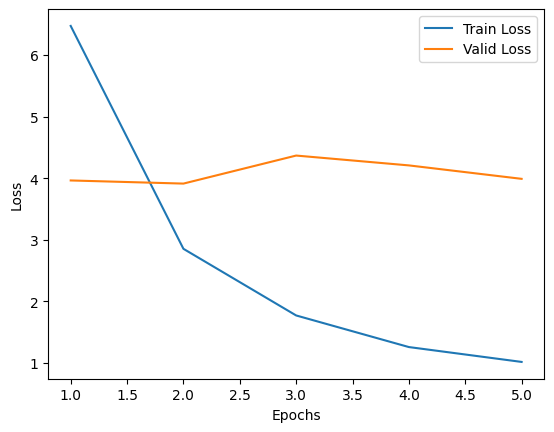

In [ ]:
# Задаем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Обучение модели
train_losses = []
valid_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader, desc='Epoch {}/{}'.format(epoch + 1, epochs)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        rating = batch['rating'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits.flatten(), rating)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            rating = batch['rating'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits.flatten(), rating)

            valid_loss += loss.item() * input_ids.size(0)

    valid_loss /= len(val_dataloader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")

# Построение графика с loss для тренировочного и валидационного наборов данных
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import torch

# Save the model's state dictionary to a file
torch.save(model.state_dict(), 'model_dfkjsj.pth')

## Test model on test dataset

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Загрузка тестовых данных
df_test = pd.read_csv('IMBD_Test.csv')

# Создание тестового DataLoader
test_dataset = ReviewDataset(df_test['Text'], df_test['rate'], tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Проверка модели на тестовом наборе данных
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions.extend(outputs.logits.flatten().cpu().numpy())

# Вычисление метрики качества (например, MSE)
true_ratings = df_test['rate'].values
mse = mean_squared_error(true_ratings, predictions)
mae = mean_absolute_error(true_ratings, predictions)
r2 = r2_score(true_ratings, predictions)
print(f'Mean Squared Error (MSE) on test set: {mse:.4f}')
print(f'Mean Absolute Error (MAE) on test set: {mae:.4f}')
print(f'R2 score on test set: {r2:.4f}')

Testing: 100%|██████████| 1563/1563 [05:12<00:00,  5.01it/s]

Mean Squared Error (MSE) on test set: 3.9016
Mean Absolute Error (MAE) on test set: 1.3107
R2 score on test set: 0.6798


In [ ]:
true_ratings = df_test['rate'].values
mse = mean_squared_error(true_ratings, predictions)
mae = mean_absolute_error(true_ratings, predictions)
r2 = r2_score(true_ratings, predictions)
print(f'Mean Squared Error (MSE) on test set: {mse:.4f}')
print(f'Mean Absolute Error (MAE) on test set: {mae:.4f}')
print(f'R2 score on test set: {r2:.4f}')

Mean Squared Error (MSE) on test set: 3.9016
Mean Absolute Error (MAE) on test set: 1.3107
R2 score on test set: 0.6798
